# Imports and fixing data

# Baby Tracking Analytics

This notebook analyzes baby tracking data to identify patterns and trends in various aspects of infant care. Using data exported from a baby tracking app, we can visualize and understand:

- Feeding patterns and amounts
- Sleep schedules and duration
- Growth measurements
- Daily care activities

The analysis helps identify trends over time, correlations between different activities, and provides insights that can help optimize baby care routines.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import datetime

from helper_methods import add_day_of_week, group_and_sum_by_day, group_and_sum_durations_by_day, \
    group_and_mean_by_day_of_week, group_and_mean_sums_by_day_of_week, filter_date_range, energy_model, \
    categorize_day_night_start_only, get_type_data, get_timeperiod_data, get_plot_kwargs, \
    get_consecutive_durations_from_two_dfs, make_year_heatmap, plot_fft_results, analyze_fft, \
    plot_heatmap_with_date_range, plot_heatmap_with_date_range_transpose, NIGHT_START, MORNING_START, SLEEP_ERR, \
    BOTTLE_ERR, to_datetime, to_numeric, get_comments, TIME_PERIODS


In [2]:
pd.options.mode.copy_on_write = True

To make a new json file, do the following in this directory:
```
node convert_to_json.mjs PATH_TO_REALM.realm ./export.json
```

In [3]:
import json

# Open and read the JSON file
with open(("export.json"), 'r') as file:
# with open(("28-02-2025 07_49_03 mybaby-default.json"), 'r') as file:
    data = json.load(file)

full_df = pd.DataFrame.from_dict(data["EventItem"])
# full_df = full_df.set_index('id')

custom_start_date = '2024-10-01'
custom_end_date = '2025-06-29'

In [4]:
full_df.columns

Index(['id', 'babyId', 'comment', 'photo', 'type', 'enteredDate',
       'customComment', 'leftStart', 'leftEnd', 'rightStart', 'rightEnd',
       'leftSeconds', 'rightSeconds', 'mixType', 'bottleAmount',
       'bottleAmountOunce', 'weight', 'height', 'headCirc', 'temperature',
       'weightPounds', 'heightInches', 'headCircInches', 'temperatureFah',
       'breast', 'singleTimerStart', 'singleTimerSeconds',
       'doubleLeftTimerStart', 'doubleRightTimerStart',
       'doubleLeftTimerSeconds', 'doubleRightTimerSeconds'],
      dtype='object')

In [5]:
pd.unique(full_df.loc[:,"type"])

array(['lactation', 'bottle', 'pumping', 'taking_med', 'diaper',
       'temperature', 'vaccination', 'weight', 'height', 'head_circ',
       'bathing', 'sleep', 'custom_achieve', 'stroll', 'lure'],
      dtype=object)

## single instance

In [6]:
full_df.iloc[-1]

id                         4C8F59DA-A9EE-4412-8442-4C6C346E9B42
babyId                     50269EA9-7196-43CC-AAC7-996E4154C610
comment                                                        
photo                                                      None
type                                                     bottle
enteredDate                            2025-07-02T01:35:32.000Z
customComment                                                  
leftStart                                                  None
leftEnd                                                    None
rightStart                                                 None
rightEnd                                                   None
leftSeconds                                                   0
rightSeconds                                                  0
mixType                                                 mixture
bottleAmount                                                240
bottleAmountOunce                       

## Fix date and numeric fields

In [7]:
full_df = to_datetime(full_df)
full_df = to_numeric(full_df)


In [8]:
full_df.groupby('type').count()

,id,babyId,comment,photo,enteredDate,customComment,leftStart,leftEnd,rightStart,rightEnd,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
type,,,,,,,,,,,,,,,,,,,,,
bathing,54,54,54,0,54,54,54,54,0,0,...,0,0,0,54,0,20,0,0,0,0
bottle,1889,1889,1889,0,1889,1889,0,0,0,0,...,0,0,0,1889,0,0,0,0,0,0
custom_achieve,1,1,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
diaper,350,350,350,0,350,350,0,0,0,0,...,0,0,0,350,0,0,0,0,0,0
head_circ,8,8,8,0,8,8,0,0,0,0,...,0,8,0,8,0,0,0,0,0,0
height,9,9,9,0,9,9,0,0,0,0,...,9,0,0,9,0,0,0,0,0,0
lactation,156,156,156,0,156,156,156,156,0,0,...,0,0,0,156,0,0,0,0,5,4
lure,272,272,272,0,272,272,0,0,0,0,...,0,0,0,272,0,0,0,0,0,0
pumping,328,328,328,0,328,328,0,0,0,0,...,0,0,0,328,0,0,0,0,0,0


In [9]:
non_empty_strings = get_comments(full_df)


In [10]:
non_empty_strings

,id,babyId,comment,photo,type,enteredDate,customComment,leftStart,leftEnd,rightStart,...,heightInches,headCircInches,temperatureFah,breast,singleTimerStart,singleTimerSeconds,doubleLeftTimerStart,doubleRightTimerStart,doubleLeftTimerSeconds,doubleRightTimerSeconds
151,47907606-DEBC-415F-BBF5-29D8566623EA,50269EA9-7196-43CC-AAC7-996E4154C610,Gas\n,None,taking_med,2024-10-19 09:10:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
156,28405EC5-90DE-4F45-9EF4-09034D82F768,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-19 22:30:24-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
173,7D411CE4-2E1D-492A-90A1-10BA2F0B2D78,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 20:00:44-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
177,9AC2FF0A-F711-4DD3-ABFE-E6E812BBAA7E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-20 22:30:42-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
196,15711C94-D55C-4541-A27C-7F62FBBA0D0E,50269EA9-7196-43CC-AAC7-996E4154C610,Gas,None,taking_med,2024-10-21 22:30:12-04:00,med_drops,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4591,52609572-595C-4985-9A38-7CEE2B0AA2CD,50269EA9-7196-43CC-AAC7-996E4154C610,,None,diaper,2025-06-29 06:30:45-04:00,dirty,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
4598,CC1D6F2D-4209-4927-9546-1239244B8859,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-06-30 17:20:40-04:00,Broccoli carrot pear,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
4602,D62BFBF5-B423-4974-BB00-610363A2E737,50269EA9-7196-43CC-AAC7-996E4154C610,,None,lure,2025-06-30 12:00:30-04:00,Veal corn peas zucchini,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN
4603,011511B0-1E2A-487A-8EE0-76C69E9B83CA,50269EA9-7196-43CC-AAC7-996E4154C610,,None,diaper,2025-06-30 10:30:43-04:00,dirty,NaT,NaT,None,...,NaN,NaN,NaN,,None,NaN,None,None,NaN,NaN


# Plots

## Feeding

This section analyzes bottle feeding patterns including total daily intake, day vs. night feeding differences, and feeding schedules.

The visualizations help identify:
- How feeding amounts change over time as the baby grows
- Whether there are preferred feeding times or days
- Patterns in feeding frequency and volume
- How day and night feeding behaviors differ


### Daily feeding over time

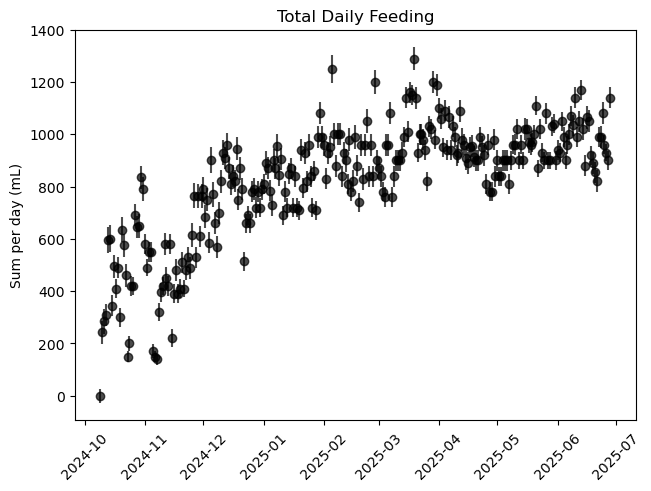

In [11]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)
df = categorize_day_night_start_only(get_type_data(filtered_df, 'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], error_value=BOTTLE_ERR)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
plt.errorbar(daily_totals.loc[:,'enteredDate'], 
             daily_totals.loc[:,'bottleAmount_sum'],
             yerr=daily_totals.loc[:,'bottleAmount_err'],
             **get_plot_kwargs('all'))
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding.png")

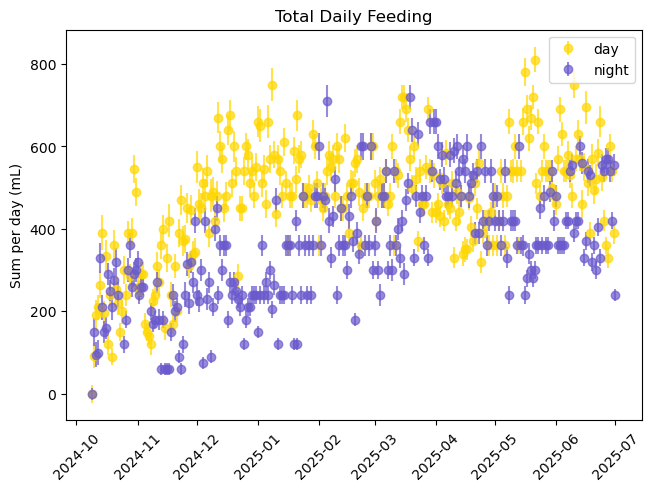

In [12]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'bottle'), 'enteredDate')
daily_totals = group_and_sum_by_day(df, 'enteredDate', ['bottleAmount'], error_value=BOTTLE_ERR)

# # Add day of week
# daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
# plt.errorbar(daily_totals.loc[:,'enteredDate'], 
#              daily_totals.loc[:,'bottleAmount_sum'], 
#              yerr=daily_totals.loc[:,'bottleAmount_err'], 
#              **get_plot_kwargs('all') )

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'enteredDate', ['bottleAmount'], error_value=BOTTLE_ERR)

    # Add day of week
    daily_totals_with_day = add_day_of_week(daily_totals, 'enteredDate')
    plt.errorbar(daily_totals['enteredDate'],
                 daily_totals['bottleAmount_sum'],
                 yerr=daily_totals['bottleAmount_err'],
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Total Daily Feeding")
plt.ylabel("Sum per day (mL)")
plt.savefig("figures/total_daily_feeding_day_night.png")

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_52620/995236790.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(energy_model, time, calories, p0=p0)


(array([19997.16666667, 20028.16666667, 20058.20833333, 20089.20833333,
        20120.20833333, 20148.20833333, 20179.16666667, 20209.16666667,
        20240.16666667, 20270.16666667]),
 [Text(19997.166666666668, 0, '2024-10'),
  Text(20028.166666666668, 0, '2024-11'),
  Text(20058.208333333332, 0, '2024-12'),
  Text(20089.208333333332, 0, '2025-01'),
  Text(20120.208333333332, 0, '2025-02'),
  Text(20148.208333333332, 0, '2025-03'),
  Text(20179.166666666668, 0, '2025-04'),
  Text(20209.166666666668, 0, '2025-05'),
  Text(20240.166666666668, 0, '2025-06'),
  Text(20270.166666666668, 0, '2025-07')])

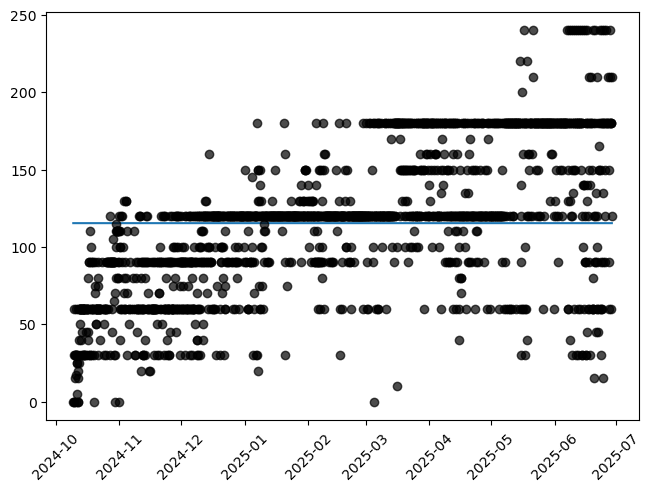

In [13]:
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)
df = get_type_data(filtered_df, 'bottle')
# plt.plot(df['enteredDate'], df['bottleAmount'],'o')

# Your data
# Assuming 'df' is your pandas DataFrame and 'your_datetime_column' is the column name
datetime_array = df.loc[:,'enteredDate'].to_numpy()
earliest_datetime = datetime_array.min()

time = [(d-earliest_datetime).total_seconds() for d in datetime_array]
calories = df.loc[:,'bottleAmount'].to_numpy()  # Calorie intake

# Initial parameter guesses
p0 = [min(calories), max(calories) - min(calories), 0.1, time[0]]

# Fit the model
popt, _ = curve_fit(energy_model, time, calories, p0=p0)

# popt now contains the optimized parameters [E0, A, k, t0]

plt.plot(datetime_array, energy_model(time, *popt))
plt.plot(datetime_array, calories, **get_plot_kwargs('all'))

plt.xticks(rotation=45)

### Feeding Frequency

In [14]:
time_bins, time_counts, freq, power_spectrum, peak_frequencies = analyze_fft(df, 'enteredDate', 'bottleAmount')

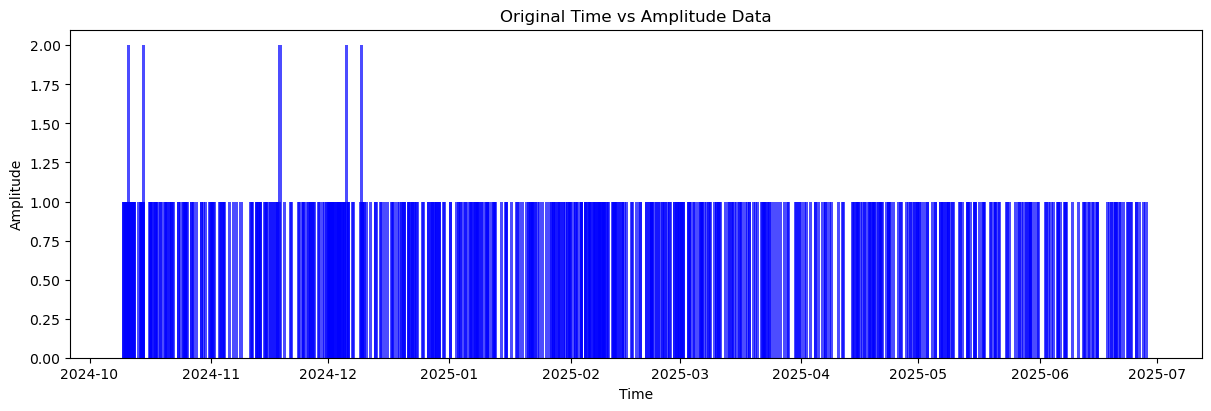

/Users/deividribeiro/Documents/Work/Projects/Baby/realm/helper_methods.py:582: RuntimeWarning: divide by zero encountered in divide
  period = (1 / freq)


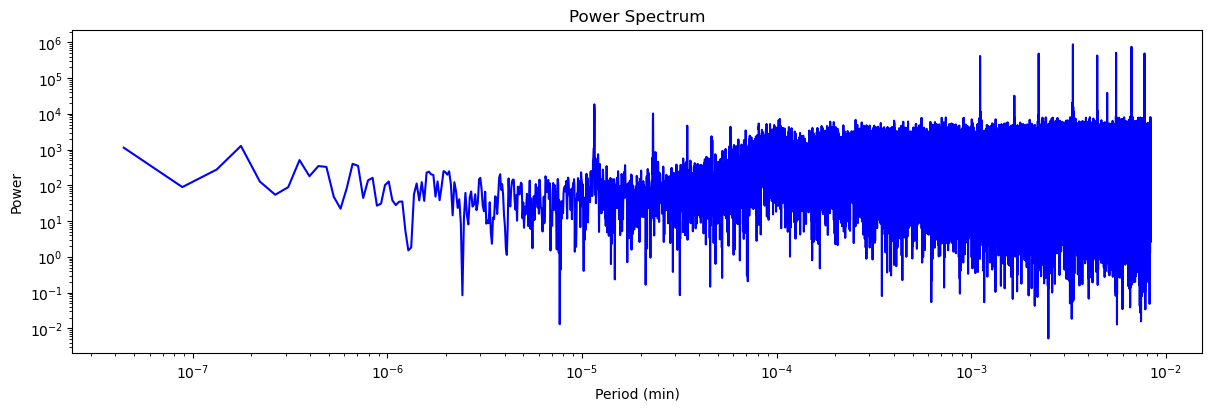

In [15]:
(fig1, ax1), (fig2, ax2) = plot_fft_results(time_bins[::20], time_counts[::20], freq, power_spectrum)

In [16]:
# Report the top 5 peak frequencies
top_5_peak_frequencies = peak_frequencies[np.argsort(power_spectrum[np.isin(freq, peak_frequencies)])][-5:]
print(f"Top 5 peak frequencies are: {(1/top_5_peak_frequencies[::-1])/60}")

Top 5 peak frequencies are: [5.00001324 2.50000662 3.         2.14285471 7.49997021]


### Feeding per day of week

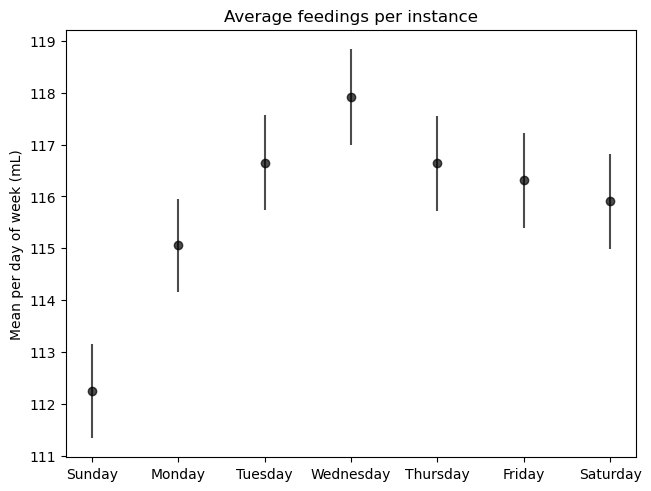

In [17]:
# Group and sum by day
daily_means = group_and_mean_by_day_of_week(get_type_data(full_df, 'bottle'), 'enteredDate', ['bottleAmount'],
                                            BOTTLE_ERR)

plt.errorbar(daily_means['day_of_week'],
             daily_means['bottleAmount_mean'],
             yerr=daily_means['bottleAmount_err'],
             **get_plot_kwargs('all'))
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week.png")

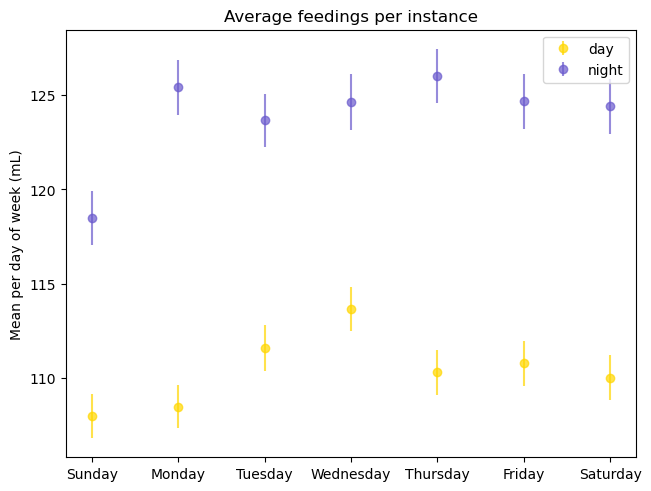

In [18]:
# Group and sum by day

df = categorize_day_night_start_only(get_type_data(full_df, 'bottle'), 'enteredDate')

for period in ['day','night']:
    daily_means = group_and_mean_by_day_of_week(get_timeperiod_data(df, period), 'enteredDate', ['bottleAmount'],
                                                BOTTLE_ERR)

    plt.errorbar(daily_means['day_of_week'],
                 daily_means['bottleAmount_mean'],
                 yerr=daily_means['bottleAmount_err'],
                 **get_plot_kwargs(period))


plt.legend()
plt.title("Average feedings per instance")
plt.ylabel("Mean per day of week (mL)")
plt.savefig("figures/average_feeding_instance_week_day_night.png")

In [19]:
df = get_type_data(full_df, 'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

### Feeding Heatmap

In [20]:
TIME_PERIODS = [
    ("2024-10-01", "2025-01-17", "21:00:00", "08:00:00"),
    ("2025-01-18", "2025-01-31", "20:00:00", "08:00:00"),
    ("2025-02-01", "2025-02-28", "19:00:00", "07:00:00"),
    ("2025-03-01", "2025-04-22", "17:45:00", "07:00:00"),
    ("2025-04-23", "2025-12-31", "18:15:00", "07:00:00")
]

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_52620/1708476797.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_52620/1708476797.py:136: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


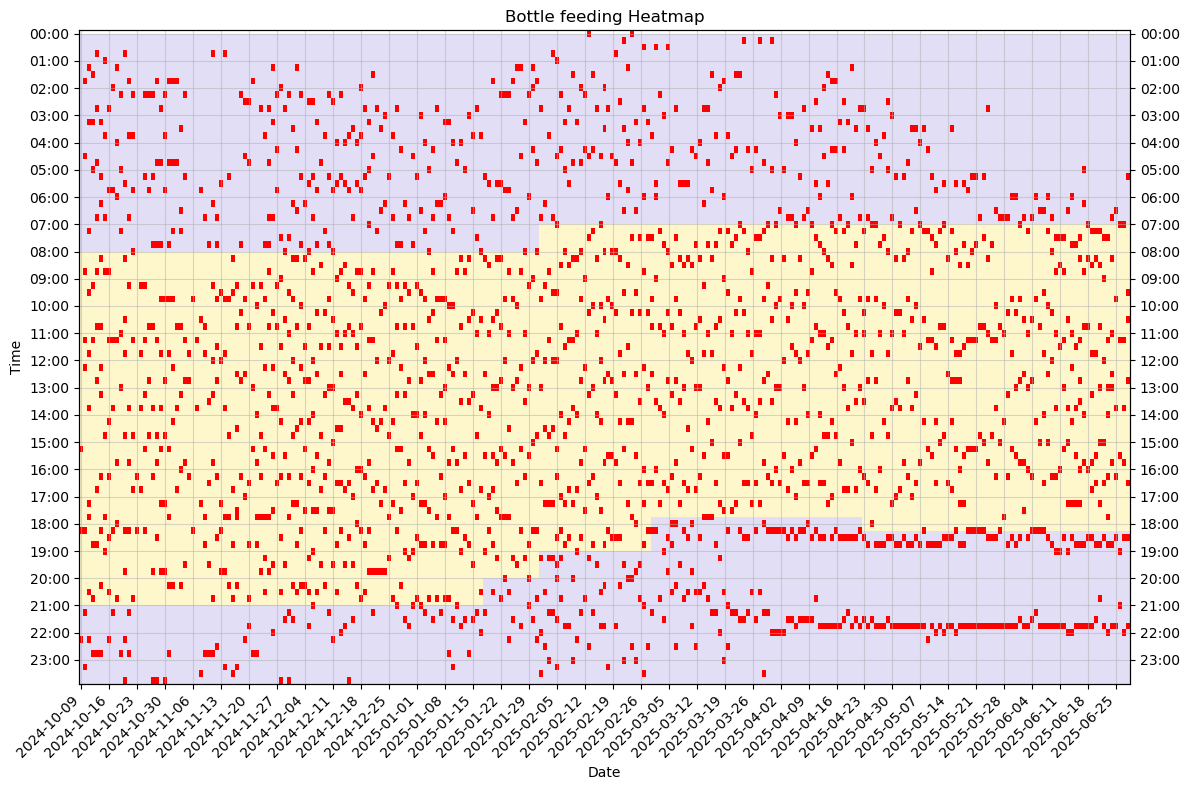

In [21]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)
df = get_type_data(filtered_df, 'bottle')
date_range = pd.date_range(start=df['enteredDate'].min().date(), end=df['enteredDate'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['enteredDate'].date()
    end_date = (row['enteredDate']+pd.Timedelta(15,'min')).date()
    start_time = row['enteredDate'].time()
    end_time = (row['enteredDate']+pd.Timedelta(15,'min')).time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

hour_time_step = 4
morning_start = 0  # 0:00
morning_start_object = datetime.datetime.strptime(MORNING_START, "%H:%M:%S").time()
morning_decimal_hour = morning_start_object.hour + morning_start_object.minute / 60 + morning_start_object.second / 3600
morning_end = morning_decimal_hour * hour_time_step

evening_start_object = datetime.datetime.strptime(NIGHT_START, "%H:%M:%S").time()
evening_start_decimal_hour = evening_start_object.hour + evening_start_object.minute / 60 + evening_start_object.second / 3600
evening_start = evening_start_decimal_hour * hour_time_step  # 18:00
evening_end = len(time_range)  # 23:59

# ax.axhspan(morning_start, morning_end, facecolor='slateblue', alpha=0.2)  # 0-7 hours
# ax.axhspan(morning_end, evening_start, facecolor='gold', alpha=0.2)  # 7-18 hours
# ax.axhspan(evening_start, evening_end, facecolor='slateblue', alpha=0.2)  # 18-24 hours
# Loop through each time period and apply the appropriate shading
for period_info in TIME_PERIODS:
    date_start, date_end, evening_start_time, morning_start_time = period_info

    # Find the column indices that correspond to the date range
    # Convert date strings to datetime objects
    start_date = pd.Timestamp(date_start).normalize()
    end_date = pd.Timestamp(date_end).normalize()

    # Find indices in date_range that fall within this period
    date_mask = (date_range.normalize() >= start_date) & (date_range.normalize() <= end_date)
    date_indices = np.where(date_mask)[0]

    if len(date_indices) == 0:
        continue  # Skip if no dates in this range

    # Get the start and end column indices
    col_start = date_indices[0]
    col_end = date_indices[-1]

    # Convert to plot coordinates (xmin and xmax are in 0-1 range)
    total_cols = len(date_range)
    xmin = col_start / total_cols
    xmax = (col_end + 1) / total_cols  # +1 to include the last column

    # Convert time strings to time objects and find row indices
    morning_start_obj = datetime.datetime.strptime(morning_start_time, "%H:%M:%S").time()
    evening_start_obj = datetime.datetime.strptime(evening_start_time, "%H:%M:%S").time()

    # Find row indices for these times
    morning_idx = time_range.searchsorted(morning_start_obj)
    evening_idx = time_range.searchsorted(evening_start_obj)
    evening_end_idx = len(time_range)

    # Create the shaded regions for morning, day, and evening using axhspan
    # For the night-morning period (midnight to morning_start)
    ax.axhspan(0, morning_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

    # For the day period (morning_start to evening_start)
    ax.axhspan(morning_idx, evening_idx, xmin=xmin, xmax=xmax,
               facecolor='gold', alpha=0.2, zorder=0)

    # For the night-evening period (evening_start to midnight)
    ax.axhspan(evening_idx, evening_end_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['none', 'red'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest')

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = morning_decimal_hour  #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval, dtype=int)
ax.set_xticks(tick_positions)
ax.set_xticklabels([date_range[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

ax2 = ax.twinx()  # Create twin axis on the right side
ax2.set_yticks(ax.get_yticks())  # Copy the y-ticks from left axis
ax2.set_yticklabels(ax.get_yticklabels())  # Copy the y-tick labels
ax2.set_ylim(ax.get_ylim())

ax.grid(True, alpha=0.5)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Bottle feeding Heatmap')

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig("figures/bottle_map.png")
plt.show()

/Users/deividribeiro/Documents/Work/Projects/Baby/realm/helper_methods.py:674: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start='00:00', end='23:59', freq='15T').time
/Users/deividribeiro/Documents/Work/Projects/Baby/realm/helper_methods.py:807: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


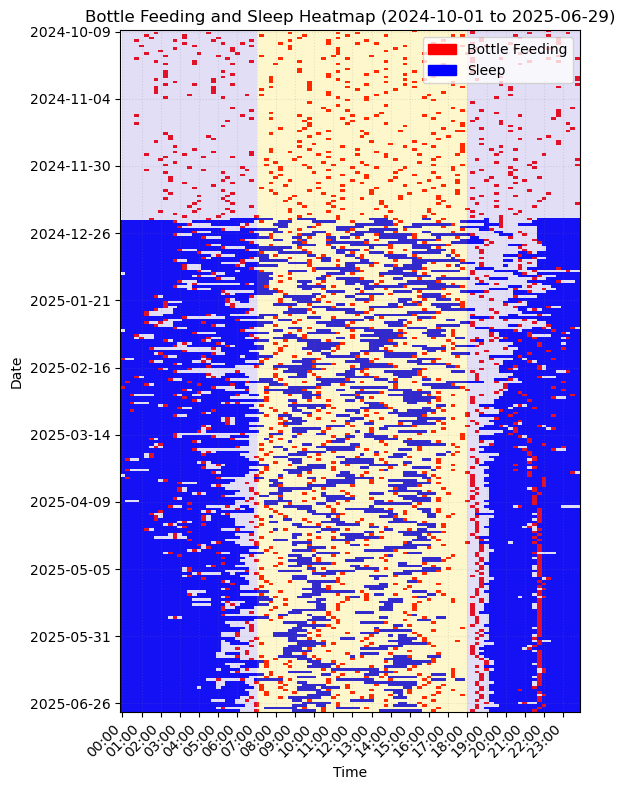

In [22]:
# Function to limit the display to a specific date range

# Usage example:
# Plot for a specific date range
ax = plot_heatmap_with_date_range(full_df,custom_start_date, custom_end_date)

# plt.sca(ax)
# plt.savefig("figures/bottle_sleep_heatmap.png")
# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

## Sleeping

Sleep is one of the most critical aspects of infant development. This section analyzes:
- Total sleep duration per day
- Sleep session length distribution
- Day vs. night sleep patterns
- Correlations between day and night sleep
- Visual representation of sleep times using heatmaps

We can observe how sleep patterns evolve over time and identify any day-of-week preferences for longer/shorter sleep.

### Sleep Durations

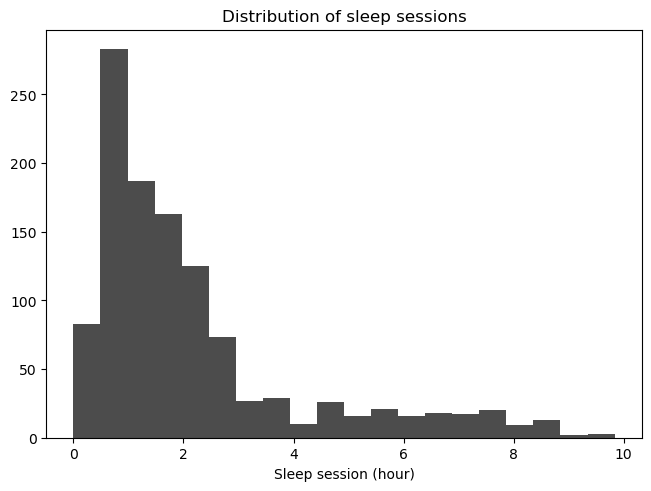

In [23]:
sleep_durations = get_type_data(full_df, 'sleep')[['singleTimerSeconds']].values

plt.hist(sleep_durations / 3600, bins=20, **get_plot_kwargs('all', plot_type='histogram'))
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist.png")

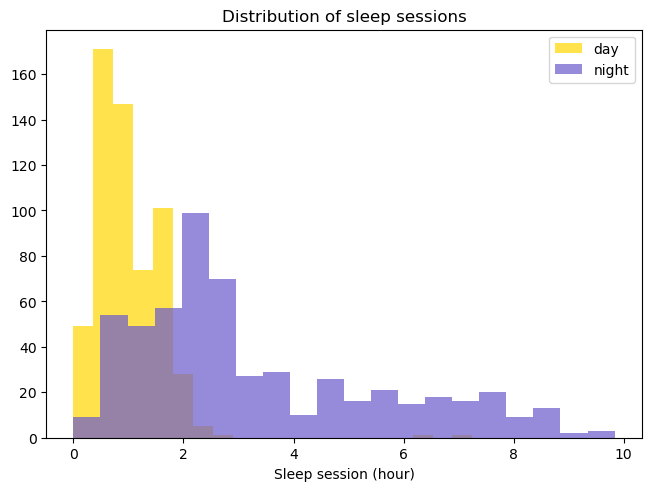

In [24]:
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')
for period in ['day','night']:
    sleep_durations = get_timeperiod_data(df, period)[['singleTimerSeconds']].values
    plt.hist(sleep_durations / 3600, bins=20, **get_plot_kwargs(period, plot_type='histogram'))

plt.legend()
plt.xlabel("Sleep session (hour)")
plt.title("Distribution of sleep sessions")
plt.savefig("figures/sleep_dist_day_night.png")

### Sleep over time, per day

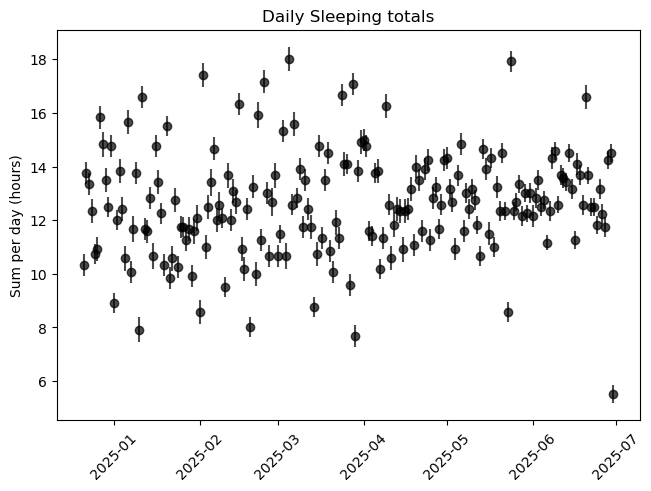

In [25]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df, 'sleep'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'],
             daily_totals['singleTimerSeconds_sum'] / 3600,
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))
plt.title("Daily Sleeping totals")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep.png")

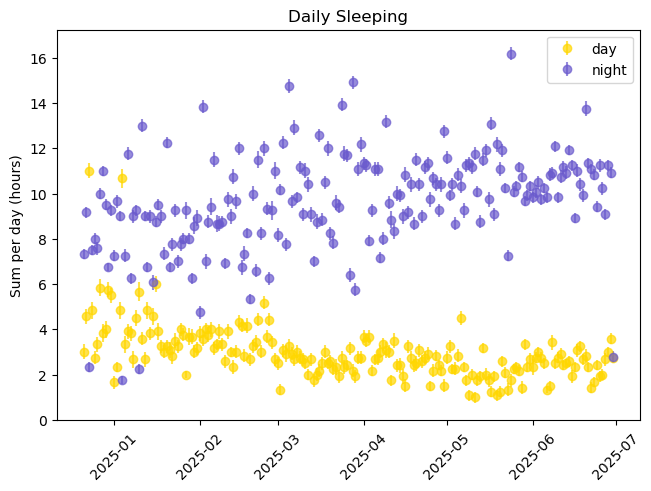

In [26]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night.png")

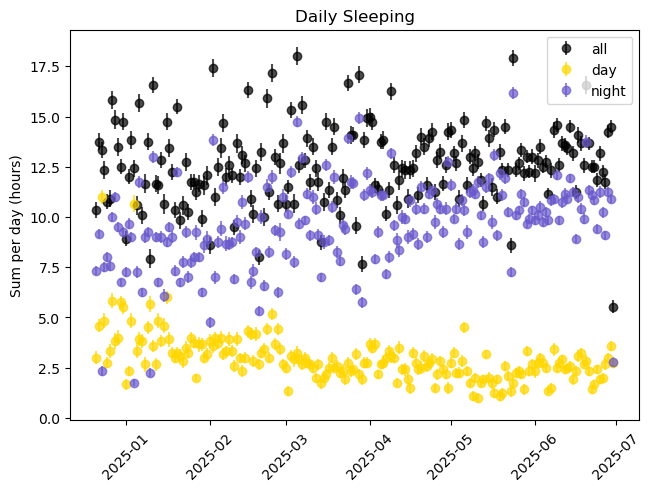

In [27]:
# Group and sum by day
daily_totals = group_and_sum_by_day(get_type_data(full_df, 'sleep'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)

# Add day of week
daily_totals_with_day = add_day_of_week(daily_totals, 'leftStart')

plt.errorbar(daily_totals['leftStart'],
             daily_totals['singleTimerSeconds_sum'] / 3600,
             yerr=daily_totals['singleTimerSeconds_err']/3600,
             **get_plot_kwargs('all'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day','night']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.xticks(rotation=45)
plt.title("Daily Sleeping")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_day_night_all.png")

### Stroller

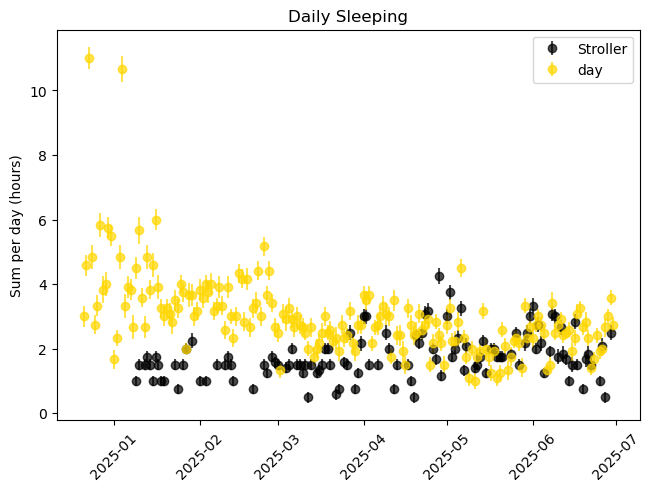

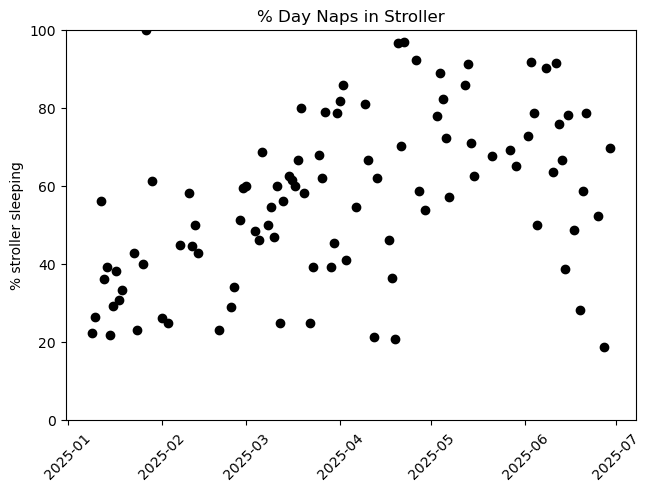

In [28]:
# Group and sum by day
daily_totals_stroller = group_and_sum_durations_by_day(get_type_data(full_df, 'stroll'), ['leftStart', 'leftEnd'], error_value=SLEEP_ERR)

# Add day of week
daily_totals_stroller_with_day = add_day_of_week(daily_totals_stroller, 'leftStart')

plt.errorbar(daily_totals_stroller['leftStart'],
             daily_totals_stroller['event_duration_sum'] / 3600,
             yerr=daily_totals_stroller['event_duration_sum_err']/3600,
             **get_plot_kwargs('all', custom_label='Stroller'))

# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')

for period in ['day']:
    daily_totals = group_and_sum_by_day(get_timeperiod_data(df, period), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
    plt.errorbar(daily_totals['leftStart'],
                 daily_totals['singleTimerSeconds_sum'] / 3600,
                 yerr=daily_totals['singleTimerSeconds_err']/3600,
                 **get_plot_kwargs(period))
plt.legend()
plt.title("Daily Sleeping")
plt.xticks(rotation=45)
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/daily_sleep_stroller.png")

merged_df = pd.merge(daily_totals_stroller, daily_totals,'inner')
plt.figure()
plt.plot(merged_df['leftStart'],
         merged_df['event_duration_sum']/merged_df['singleTimerSeconds_sum']*100,
         marker='o',
         color='k', ls='None'
        )
plt.ylim(0,100)
plt.ylabel("% stroller sleeping")
plt.xticks(rotation=45)
plt.title("% Day Naps in Stroller")
plt.savefig("figures/daily_sleep_stroller_percent.png")

### Sleep per day of week

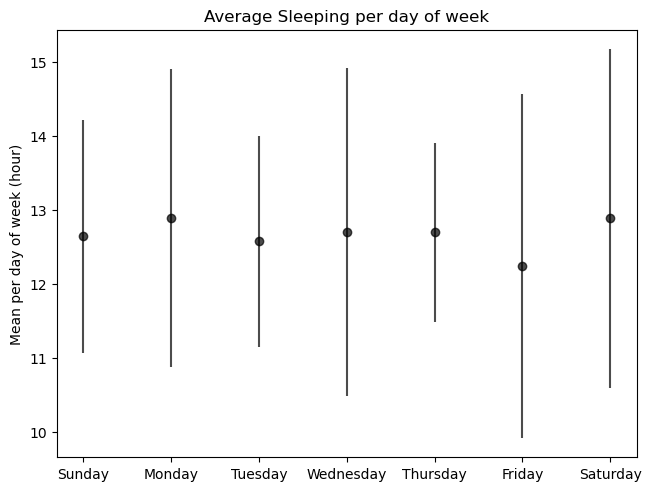

In [29]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'leftStart', custom_start_date, custom_end_date)
daily_means = group_and_mean_sums_by_day_of_week(get_type_data(filtered_df, 'sleep'), 'leftStart', ['singleTimerSeconds'],
                                                 SLEEP_ERR)

plt.errorbar(daily_means['day_of_week'],
             daily_means['singleTimerSeconds_sum_mean'] / 3600,
             yerr=daily_means['singleTimerSeconds_sum_std']/3600,
             **get_plot_kwargs('all'))
plt.title("Average Sleeping per day of week")
plt.ylabel("Mean per day of week (hour)")
plt.savefig("figures/sleep_per_weekday.png")

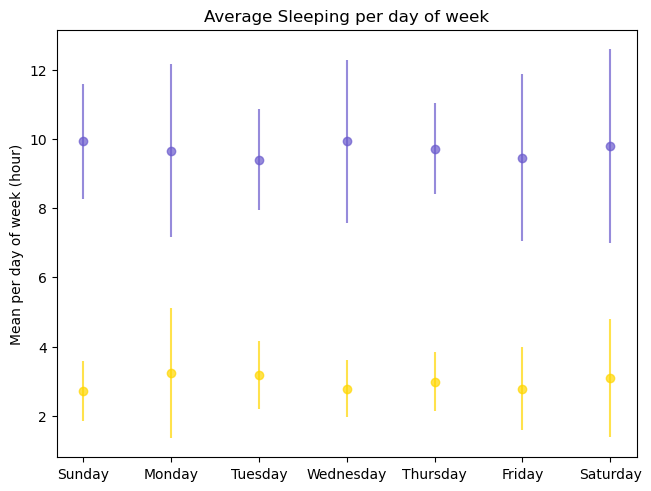

In [30]:
# Group and sum by day
for period in ['day','night']:
    filtered_df = filter_date_range(full_df, 'leftStart', custom_start_date, custom_end_date)
    filtered_df = categorize_day_night_start_only(filtered_df, 'leftStart')

    daily_means = group_and_mean_sums_by_day_of_week(get_type_data(get_timeperiod_data(filtered_df,period), 'sleep'), 'leftStart', ['singleTimerSeconds'],
                                                 SLEEP_ERR)

    plt.errorbar(daily_means['day_of_week'],
                 daily_means['singleTimerSeconds_sum_mean'] / 3600,
                 yerr=daily_means['singleTimerSeconds_sum_std']/3600,
                 **get_plot_kwargs(period))
plt.title("Average Sleeping per day of week")
plt.ylabel("Mean per day of week (hour)")
plt.savefig("figures/sleep_per_weekday_day_night.png")

### How does sum of night sleep impact sum of following day's sleep. Plot night sum vs day sum. Is there a trend line?

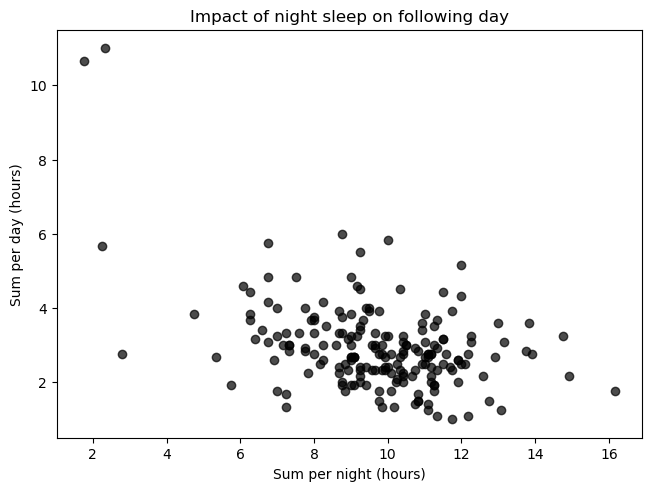

In [31]:
# Group and sum by day
df = categorize_day_night_start_only(get_type_data(full_df, 'sleep'), 'leftStart')
daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df, 'day'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
combined_df = daily_totals_night.merge(daily_totals_day,how='inner',on= "leftStart")
plt.plot(combined_df['singleTimerSeconds_sum_x'] / 3600,
         combined_df['singleTimerSeconds_sum_y'] / 3600,
         **get_plot_kwargs('all'))

plt.title("Impact of night sleep on following day")
plt.xlabel("Sum per night (hours)")
plt.ylabel("Sum per day (hours)")
plt.savefig("figures/sleep_night_on_day.png")

### How does sum of day sleep impact sum of following night's sleep. Plot day sum vs night sum. Is there a trend line?

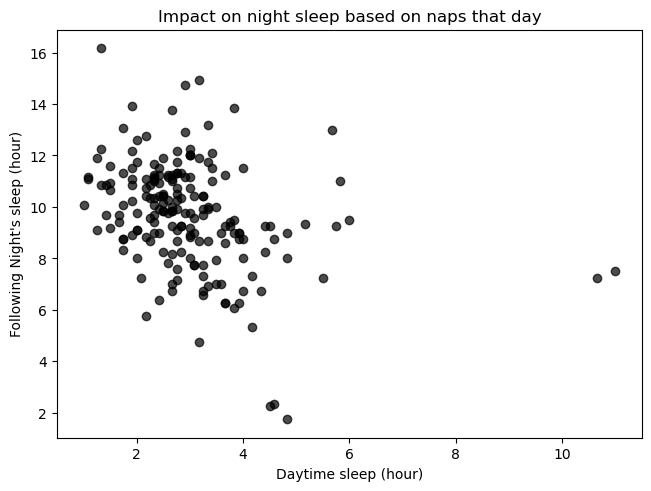

In [32]:
# Group and sum by day
filtered_df = filter_date_range(full_df, 'leftStart', custom_start_date, custom_end_date)
df = categorize_day_night_start_only(get_type_data(filtered_df, 'sleep'), 'leftStart')

daily_totals_night = group_and_sum_by_day(get_timeperiod_data(df, 'night'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)
daily_totals_day = group_and_sum_by_day(get_timeperiod_data(df, 'day'), 'leftStart', ['singleTimerSeconds'], error_value=SLEEP_ERR)

results = get_consecutive_durations_from_two_dfs(daily_totals_day, daily_totals_night, date_column='leftStart', duration_column='singleTimerSeconds_sum')
plt.plot(results[:,1] / 3600,results[:,3] / 3600, **get_plot_kwargs('all'))

plt.xlabel("Daytime sleep (hour)")
plt.ylabel("Following Night's sleep (hour)")
plt.title("Impact on night sleep based on naps that day")
plt.savefig("figures/sleep_day_on_night.png")

### Sleep heatmap

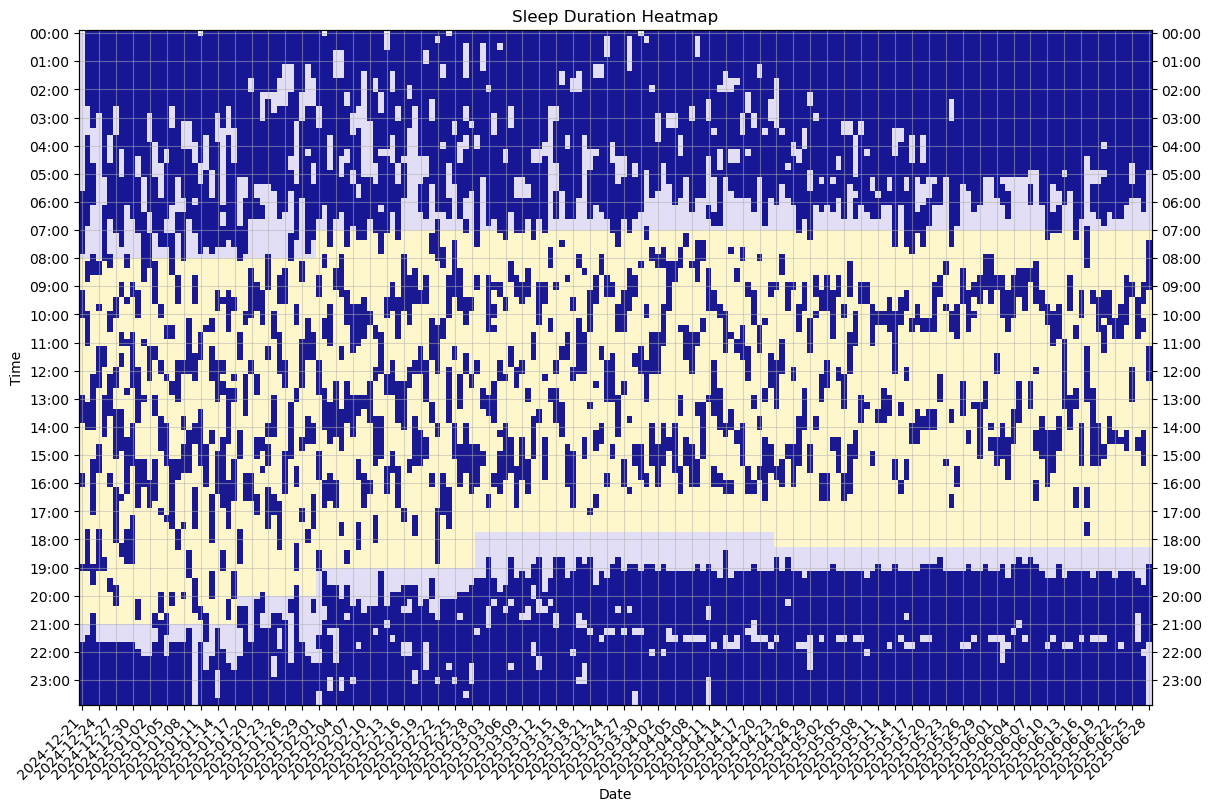

In [33]:
# Assuming you have a DataFrame 'df' with columns 'leftStart' and 'leftEnd'
# If not, you can create a sample DataFrame like this:
# df = pd.DataFrame({
#     'leftStart': pd.date_range(start='2023-01-01 09:00', end='2023-01-10 09:00', freq='D'),
#     'leftEnd': pd.date_range(start='2023-01-01 17:00', end='2023-01-10 17:00', freq='D')
# })

# Create a date range for x-axis
filtered_df = filter_date_range(full_df, 'enteredDate', custom_start_date, custom_end_date)

df = get_type_data(filtered_df, 'sleep')
date_range = pd.date_range(start=df['leftStart'].min().date(), end=df['leftEnd'].max().date())

# Create time range for y-axis (24 hours, in 15-minute intervals)
time_range = pd.date_range(start='00:00', end='23:59', freq='15min').time

# Create a 2D array to hold the heatmap data
heatmap_data = np.zeros((len(time_range), len(date_range)))

# Fill the heatmap data
for _, row in df.iterrows():
    start_date = row['leftStart'].date()
    end_date = row['leftEnd'].date()
    start_time = row['leftStart'].time()
    end_time = row['leftEnd'].time()
    # print(f"{row['leftStart']} to {row['leftEnd']} {row['leftEnd']-row['leftStart']}")
    
    date_idx_start = np.where(date_range.normalize() == pd.Timestamp(start_date).normalize())[0][0]
    date_idx_end = np.where(date_range.normalize() == pd.Timestamp(end_date).normalize())[0][0]
    
    start_idx = time_range.searchsorted(start_time)
    end_idx = time_range.searchsorted(end_time)
    
    if date_idx_start == date_idx_end:
        heatmap_data[start_idx:end_idx, date_idx_start] = 1
    else:
        heatmap_data[start_idx:, date_idx_start] = 1
        heatmap_data[:end_idx, date_idx_end] = 1
        if date_idx_end - date_idx_start > 1:
            heatmap_data[:, date_idx_start+1:date_idx_end] = 1

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

hour_time_step = 4

# Loop through each time period and apply the appropriate shading
for period_info in TIME_PERIODS:
    date_start, date_end, evening_start_time, morning_start_time = period_info

    # Find the column indices that correspond to the date range
    # Convert date strings to datetime objects
    start_date = pd.Timestamp(date_start).normalize()
    end_date = pd.Timestamp(date_end).normalize()

    # Find indices in date_range that fall within this period
    date_mask = (date_range.normalize() >= start_date) & (date_range.normalize() <= end_date)
    date_indices = np.where(date_mask)[0]

    if len(date_indices) == 0:
        continue  # Skip if no dates in this range

    # Get the start and end column indices
    col_start = date_indices[0]
    col_end = date_indices[-1]

    # Convert to plot coordinates (xmin and xmax are in 0-1 range)
    total_cols = len(date_range)
    xmin = col_start / total_cols
    xmax = (col_end + 1) / total_cols  # +1 to include the last column

    # Convert time strings to time objects and find row indices
    morning_start_obj = datetime.datetime.strptime(morning_start_time, "%H:%M:%S").time()
    evening_start_obj = datetime.datetime.strptime(evening_start_time, "%H:%M:%S").time()

    # Find row indices for these times
    morning_idx = time_range.searchsorted(morning_start_obj)
    evening_idx = time_range.searchsorted(evening_start_obj)
    evening_end_idx = len(time_range)

    # Create the shaded regions for morning, day, and evening using axhspan
    # For the night-morning period (midnight to morning_start)
    ax.axhspan(0, morning_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

    # For the day period (morning_start to evening_start)
    ax.axhspan(morning_idx, evening_idx, xmin=xmin, xmax=xmax,
               facecolor='gold', alpha=0.2, zorder=0)

    # For the night-evening period (evening_start to midnight)
    ax.axhspan(evening_idx, evening_end_idx, xmin=xmin, xmax=xmax,
               facecolor='slateblue', alpha=0.2, zorder=0)

# Create custom colormap (white for 0, blue for 1)
cmap = ListedColormap(['none', 'darkblue'])

# Plot the heatmap
im = ax.imshow(heatmap_data, aspect='auto', cmap=cmap, interpolation='nearest', alpha=0.9)

# Set x-axis ticks and labels
num_dates = len(date_range)
tick_interval = 3 #num_dates // 25 # Use integer division to get 1/4 of the ticks
tick_positions = np.arange(0, num_dates, tick_interval)
ax.set_xticks(tick_positions)
ax.set_xticklabels(date_range[tick_positions].strftime('%Y-%m-%d'), rotation=45, ha='right')

# Set y-axis ticks and labels (every hour)
hour_indices = np.arange(0, len(time_range), 4)
ax.set_yticks(hour_indices)
ax.set_yticklabels([t.strftime('%H:%M') for t in time_range[hour_indices]])

ax2 = ax.twinx()  # Create twin axis on the right side
ax2.set_yticks(ax.get_yticks())  # Copy the y-ticks from left axis
ax2.set_yticklabels(ax.get_yticklabels())  # Copy the y-tick labels
ax2.set_ylim(ax.get_ylim())

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Time')
ax.set_title('Sleep Duration Heatmap')

ax.grid(True, alpha=0.5)

# Add colorbar
# cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
# cbar.set_ticklabels(['Awake', 'Sleeping'])

# Adjust layout and display the plot
# plt.tight_layout()

plt.savefig("figures/sleep_map.png")
plt.show()

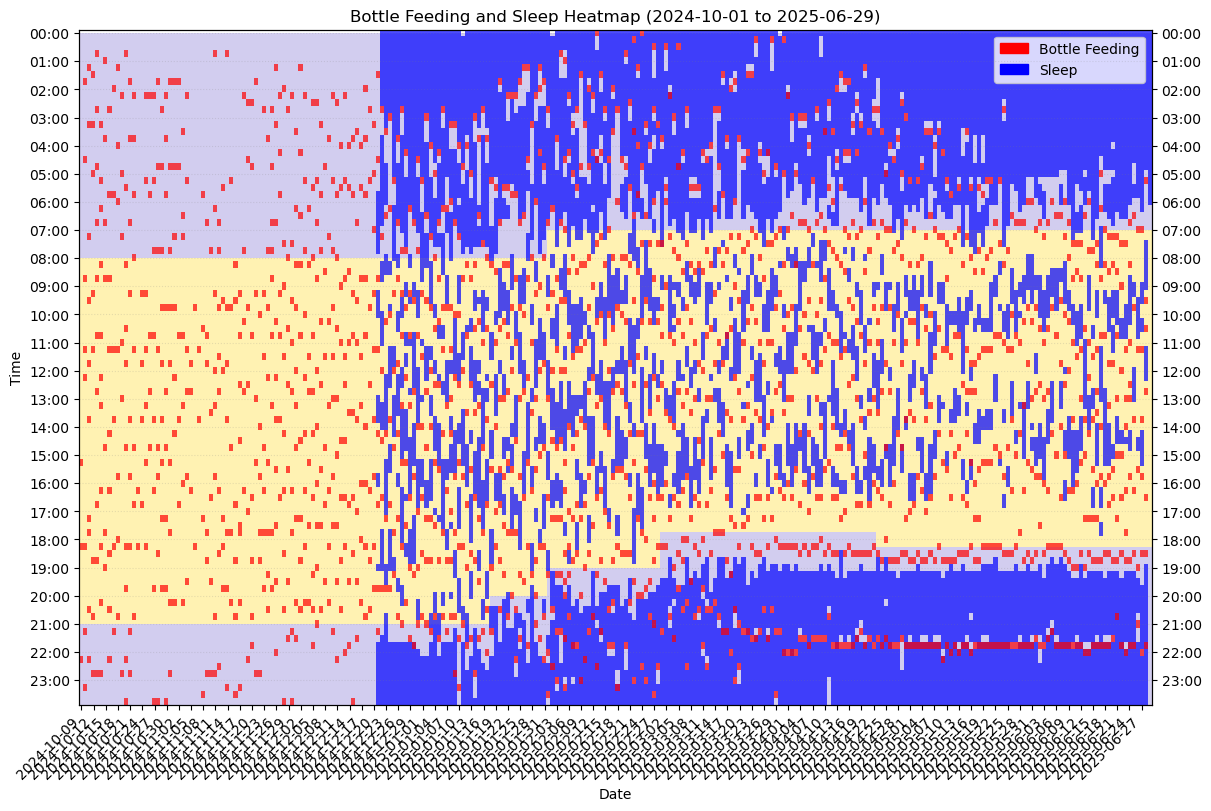

In [34]:
# '2024-12-21

ax = plot_heatmap_with_date_range_transpose(full_df, custom_start_date, custom_end_date)

plt.sca(ax)
plt.savefig("figures/bottle_sleep_heatmap.png")

# Or to plot the entire range
# plot_heatmap_with_date_range(min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d'))

In [35]:
combined_df = full_df[(full_df['type']=='sleep') | (full_df['type']=='bottle')]
combined_df['combined_date'] = combined_df.apply(lambda row: row['leftStart'] if row['type'] == 'sleep' else row['enteredDate'], axis=1)
combined_df['combined_date'] = pd.to_datetime(combined_df['combined_date'])
df_sorted = combined_df.sort_values(by='combined_date')



## Vitals

This section tracks physical growth measurements including:
- Weight progression
- Height/length increases
- Head circumference growth

These measurements help ensure the baby is developing at a healthy rate and can identify any growth spurts or slowdowns.

### Growth

/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_52620/823976067.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_52620/823976067.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_52620/823976067.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/var/folders/74/3kz1j0p93vs_xz126s_l0f1h0000gq/T/ipykernel_52620/823976067.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


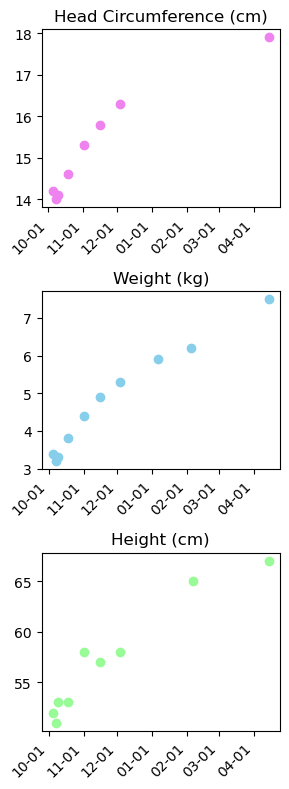

In [36]:
head_circ = get_type_data(full_df, "head_circ")[['enteredDate', 'headCircInches']]
weight = get_type_data(full_df, "weight")[['enteredDate', 'weight']]
height = get_type_data(full_df, "height")[['enteredDate', 'height']]

fig,ax=plt.subplots(3,1, figsize=(3,8))

ax[0].plot(head_circ.values[:,0], head_circ.values[:,1], label='head_circ',marker='o',ls='None', c='violet')
ax[1].plot(weight.values[:,0], weight.values[:,1], label='weight',marker='o',ls='None', c='skyblue')
ax[2].plot(height.values[:,0], height.values[:,1], label='height',marker='o',ls='None', c='palegreen')


ax[0].set_title("Head Circumference (cm)",)
ax[1].set_title("Weight (kg)")
ax[2].set_title("Height (cm)")

date_formatter = mdates.DateFormatter("%m-%d")
for i in range(3):
    # Format x-axis to show only month-day
    ax[i].xaxis.set_major_formatter(date_formatter)

    # Get current tick labels
    labels = ax[i].get_xticklabels()

    # Set the rotated labels
    ax[i].set_xticklabels(labels, rotation=45, ha='right')
    # ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)

plt.tight_layout()
plt.savefig("figures/growth.png")

In [37]:
get_type_data(full_df, "height")[['enteredDate', 'height']]

,enteredDate,height
992,2024-10-04 12:00:55-04:00,52.0
993,2024-10-07 12:00:22-04:00,51.0
994,2024-10-09 12:00:44-04:00,53.0
995,2024-10-18 12:00:04-04:00,53.0
996,2024-11-01 12:00:21-04:00,58.0
997,2024-11-15 12:00:44-05:00,57.0
998,2024-12-03 12:00:04-05:00,58.0
2088,2025-02-06 11:33:52.852000-05:00,65.0
3333,2025-04-14 13:00:10-04:00,67.0


In [38]:
get_type_data(full_df, "height")[['enteredDate', 'height']].values[:, 0]

array([Timestamp('2024-10-04 12:00:55-0400', tz='US/Eastern'),
       Timestamp('2024-10-07 12:00:22-0400', tz='US/Eastern'),
       Timestamp('2024-10-09 12:00:44-0400', tz='US/Eastern'),
       Timestamp('2024-10-18 12:00:04-0400', tz='US/Eastern'),
       Timestamp('2024-11-01 12:00:21-0400', tz='US/Eastern'),
       Timestamp('2024-11-15 12:00:44-0500', tz='US/Eastern'),
       Timestamp('2024-12-03 12:00:04-0500', tz='US/Eastern'),
       Timestamp('2025-02-06 11:33:52.852000-0500', tz='US/Eastern'),
       Timestamp('2025-04-14 13:00:10-0400', tz='US/Eastern')],
      dtype=object)

## Wellbeing

This section tracks various aspects of daily care and health:
- Bath frequency and patterns
- Medication administration (gas drops)
- Diaper changes (frequency and type)

These visualizations help identify patterns in routine care activities and can help optimize scheduling.

### Baths

30


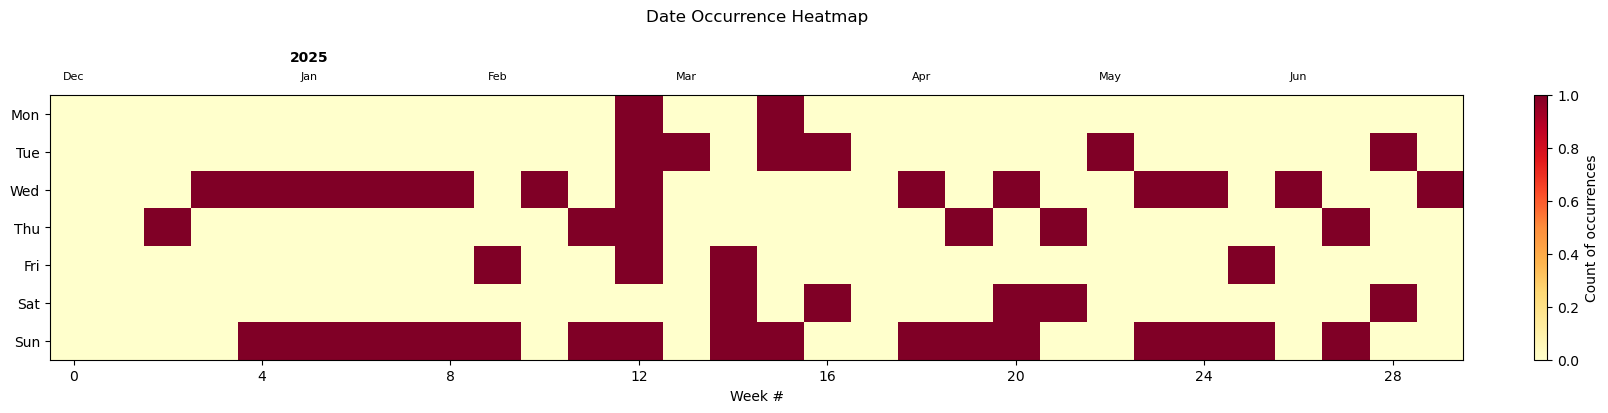

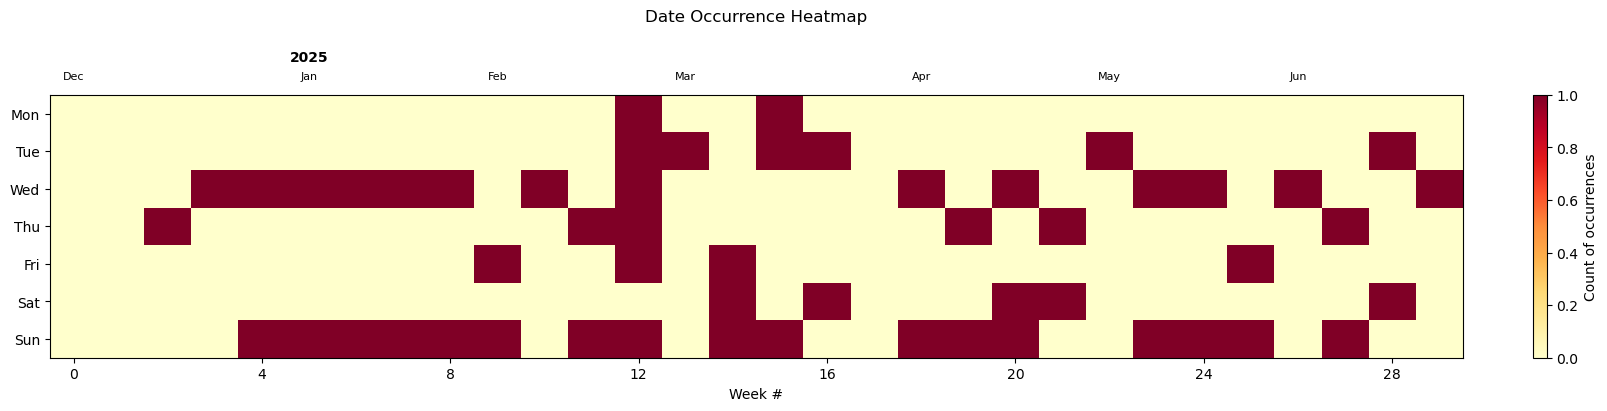

In [39]:
# Convert Series to list of dates
dates = get_type_data(full_df, "bathing")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/bath_map.png")

### Gas Drops

37


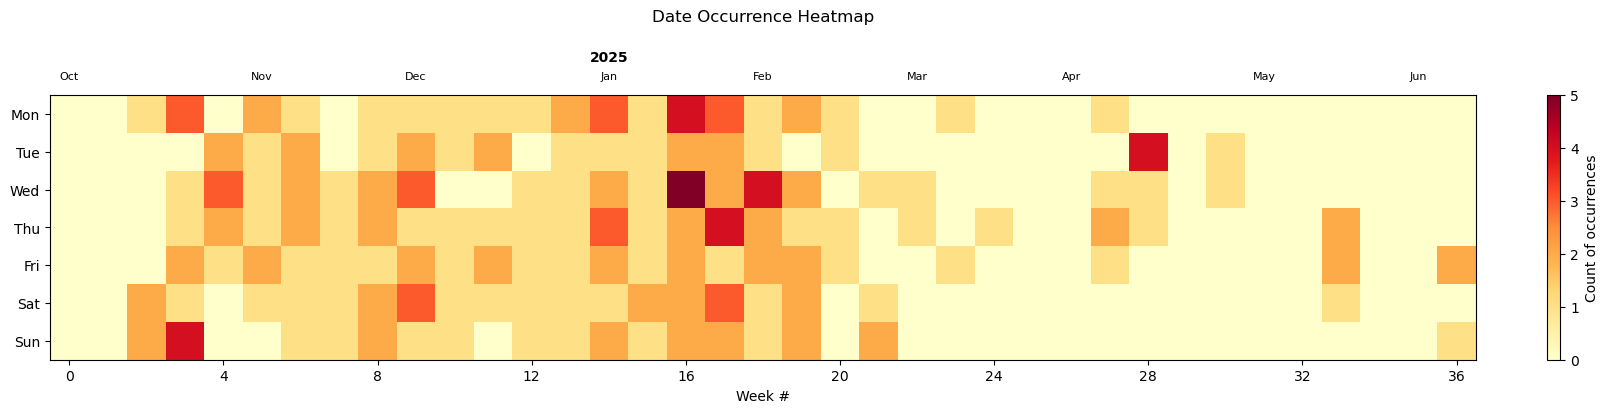

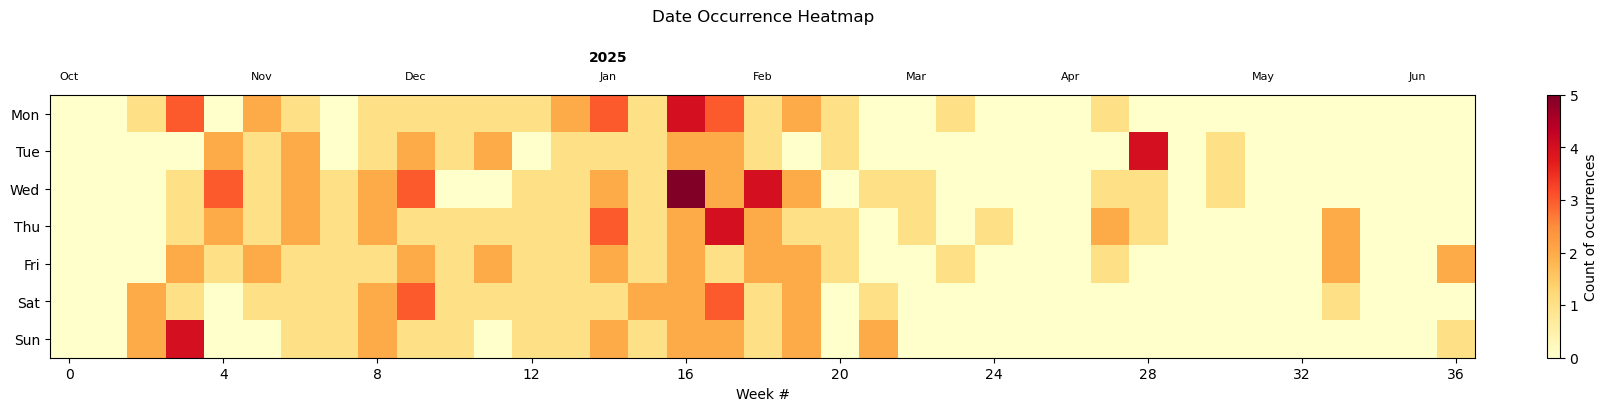

In [40]:
# Convert Series to list of dates
dates = get_type_data(full_df, "taking_med")['enteredDate'].dt.date
ax = make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/gas_drops_map.png")

### Diapers

39


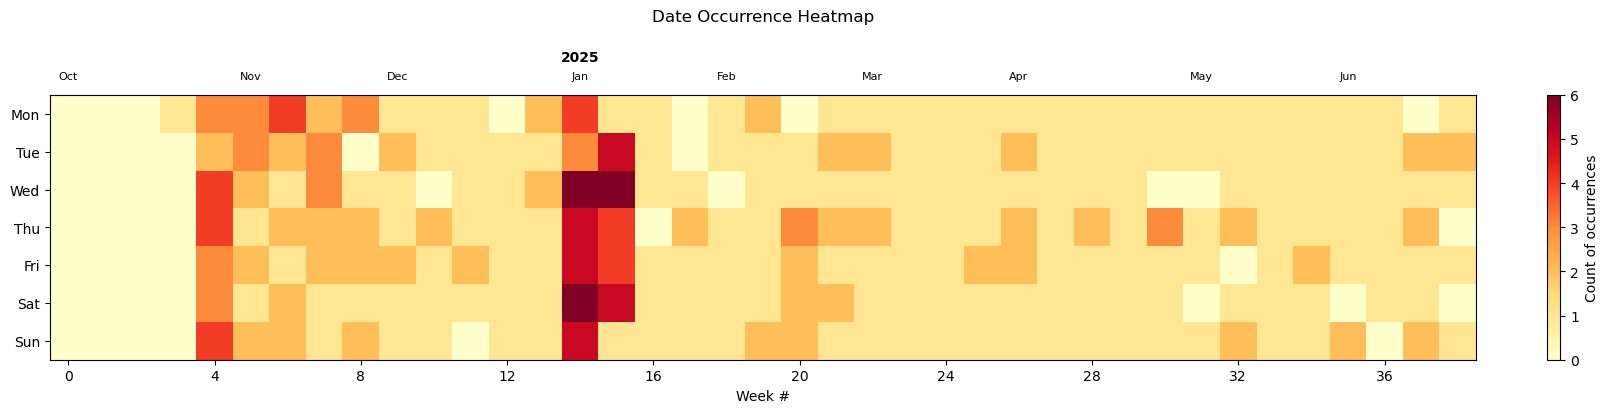

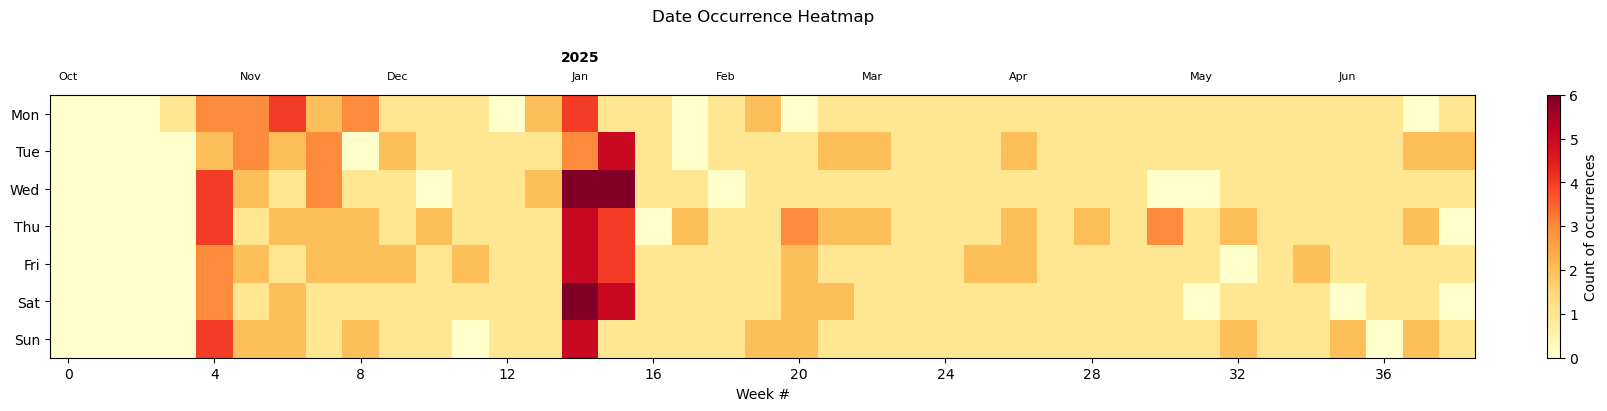

In [41]:
# Convert Series to list of dates
dates = get_type_data(full_df, "diaper")['enteredDate'].dt.date
ax= make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")

39


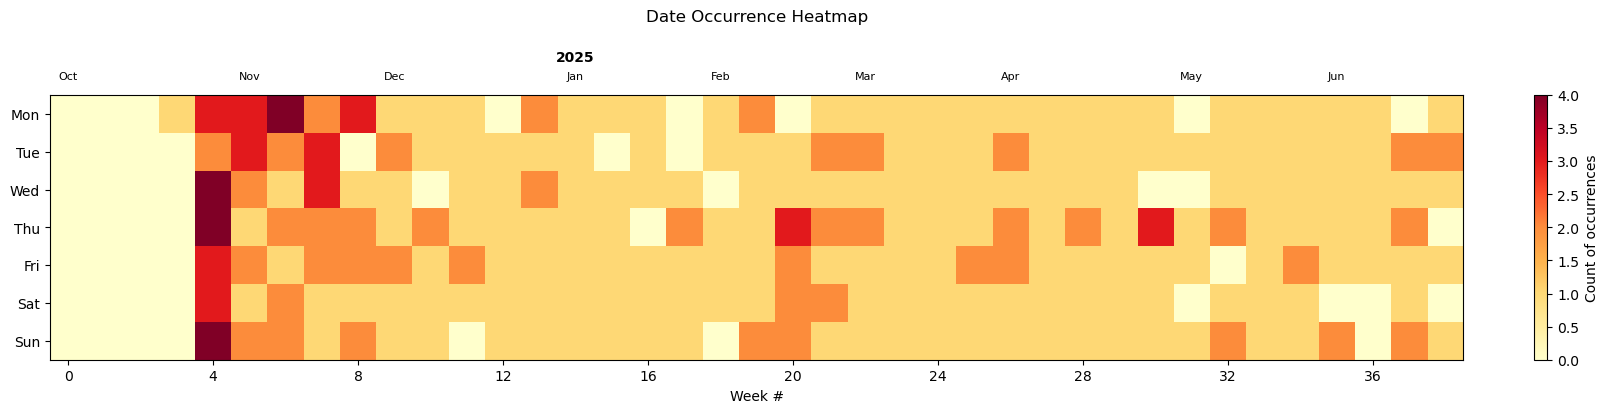

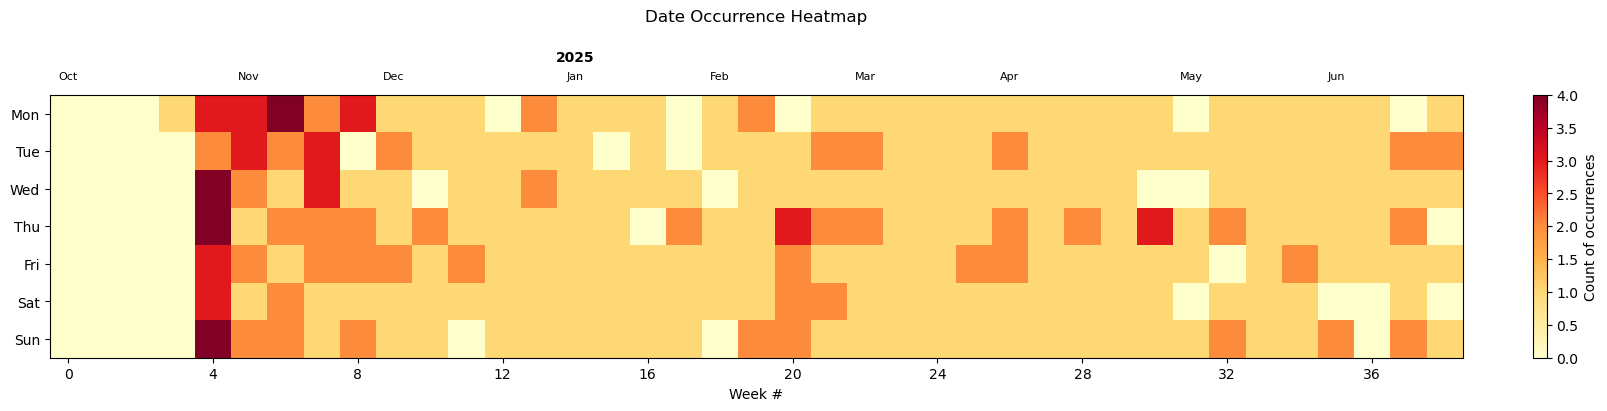

In [42]:
dates= get_type_data(full_df, "diaper").query("customComment=='dirty'")['enteredDate'].dt.date
ax= make_year_heatmap(dates)
plt.sca(ax)
plt.savefig("figures/diapers_map.png")

In [44]:
np.unique(full_df.type)

array(['bathing', 'bottle', 'custom_achieve', 'diaper', 'head_circ',
       'height', 'lactation', 'lure', 'pumping', 'sleep', 'stroll',
       'taking_med', 'temperature', 'vaccination', 'weight'], dtype=object)

In [45]:
np.unique(full_df[full_df['type']==('lure')]['customComment'])

array(['Acorn squash broccoli veal soup yellow squash ',
       'Acorn squash mango apple oat ',
       'Acorn squash mixed veggies chicken soup oat', 'Apple', 'Apple ',
       'Apple / oat / water', 'Apple / oatmeal / water',
       'Apple / oats / water', 'Apple / water', 'Apple banana ',
       'Apple banana oat ', 'Apple banana toast', 'Apple carrot ',
       'Apple carrot oat', 'Apple mango acorn squash oat', 'Apple oat',
       'Apple oat ', 'Apple pea corn oat', 'Apple pea mango oat',
       'Apple pear', 'Apple pear blueberry oat', 'Apple pear oat',
       'Apple pear oats', 'Apple pear pea oat', 'Apple pear zucchini',
       'Apple pear zucchini oat', 'Apple zucchini', 'Apple zucchini ',
       'Asparagus acorn squash oat', 'Asparagus acorns squash corn oat',
       'Asparagus squash zucchini oats ', 'Avocado ',
       'Avocado / apple / oats / water', 'Avocado banana ',
       'Avocado green bean', 'Avocado toast',
       'Avocado/ apple / oat / water', 'Banana', 'Banana / oa